In [2]:
source('/data/srlab/ik936/Roche/R/libs.R')
source('/data/srlab/ik936/Roche/R/utils.R') 
library(pheatmap)
library(ggridges)
library(presto)


# Load cached results 

In [63]:
roche <- readRDS('/data/srlab/ik936/Fiona/data/fib_object_040720.rds')

roche$meta_data$Class <- factor(roche$meta_data$Class, c('low', 'int', 'high'))
roche$proportions_fibro$Class <- factor(roche$proportions_fibro$Class, c('low', 'int', 'high'))
roche$proportions_total$Class <- factor(roche$proportions_total$Class, c('low', 'int', 'high'))


CellType_levels <- c(
    'PDGFRA+ fibroblasts',
    'ABCA8+ fibroblasts',
    'Inflammatory fibroblasts',
    'Myofibroblasts',
    'Endothelial cells',
    'Pericytes'
)

roche$meta_data$CellType <- factor(roche$meta_data$CellType, CellType_levels)
roche$proportions_fibro$CellType <- factor(roche$proportions_fibro$CellType, CellType_levels)
roche$proportions_total$CellType <- factor(roche$proportions_total$CellType, CellType_levels)


In [4]:
set.seed(1)

# colors_global <- c(
#     low = 'grey', int = muted('blue'), high = muted('red') ## Class
# )

# .x <- tableau_color_pal()(6) %>% sample() ## randomly permute
# names(.x) <- CellType_levels

# colors_global <- c(colors_global, .x)

colors_global <- c(
    ## Inflammatory Status
    low = 'grey',
    int = '#3A3A98',
    high = '#832424',
    ## Cell Types
    `PDGFRA+ fibroblasts` = '#4E79A7',
    `ABCA8+ fibroblasts` = '#76B7B2',
    `Inflammatory fibroblasts` = '#E15759',
    Myofibroblasts = '#EDC948',
    `Endothelial cells` = '#F28E2B',
    Pericytes = '#59A14F'
)

paletteLength <- 50
colors_heat <- c(RColorBrewer::brewer.pal(10, "RdBu")[1:5], "white", 

            RColorBrewer::brewer.pal(10, "RdBu")[6:10])
colors_heat <- colorRampPalette(colors_heat)(paletteLength) %>% rev()



# Figures

## UMAP by Class

In [5]:
do_scatter <- function (umap_use, meta_data, label_name, no_guides = TRUE, 
    do_labels = TRUE, nice_names, palette_use = colors_overload, 
    pt_size = 4, point_size = 0.5, pt_shape = ".", base_size = 12, 
    do_points = TRUE, do_density = FALSE, h = 6, w = 8) 
{
    plt_df <- umap_use %>% data.frame() %>% cbind(meta_data) %>% 
        dplyr::sample_frac(1L)
    plt_df$given_name <- plt_df[[label_name]]
    if (!missing(nice_names)) {
        plt_df %<>% dplyr::inner_join(nice_names, by = "given_name") %>% 
            subset(nice_name != "" & !is.na(nice_name))
        plt_df[[label_name]] <- plt_df$nice_name
    }
    plt <- plt_df %>% ggplot(aes_string("X1", "X2", col = label_name, 
        fill = label_name)) + theme_tufte(base_size = base_size) + 
        theme(panel.background = element_rect(fill = NA, color = "black")) + 
        guides(color = guide_legend(override.aes = list(stroke = 1, 
            alpha = 1, shape = 16, size = 4)), alpha = FALSE) + 
        scale_color_manual(values = palette_use) + scale_fill_manual(values = palette_use) + 
        theme(plot.title = element_text(hjust = 0.5)) + labs(x = "UMAP 1", 
        y = "UMAP 2")
    if (do_points) 
        plt <- plt + geom_point_rast(shape = pt_shape, width = w, height = h)
    if (do_density) 
        plt <- plt + geom_density_2d()
    if (no_guides) 
        plt <- plt + guides(col = FALSE, fill = FALSE, alpha = FALSE)
    if (do_labels) {
        plt <- plt + geom_text_repel(data = data.table(plt_df)[, 
            .(X1 = mean(X1), X2 = mean(X2)), by = label_name], 
            label.size = NA, aes_string(label = label_name), 
            color = "black", size = pt_size, alpha = 1, segment.size = 0) + 
            guides(col = FALSE, fill = FALSE)
    }
    return(plt)
}

In [6]:
## sample the same number of cells for visualization
set.seed(1)
nsample <- min(table(roche$meta_data$Class))
idx_plot <- roche$meta_data %>% 
    tibble::rowid_to_column('idx') %>% 
    group_by(Class) %>% 
    sample_n(nsample) %>% 
    ungroup() %>% 
    with(idx)


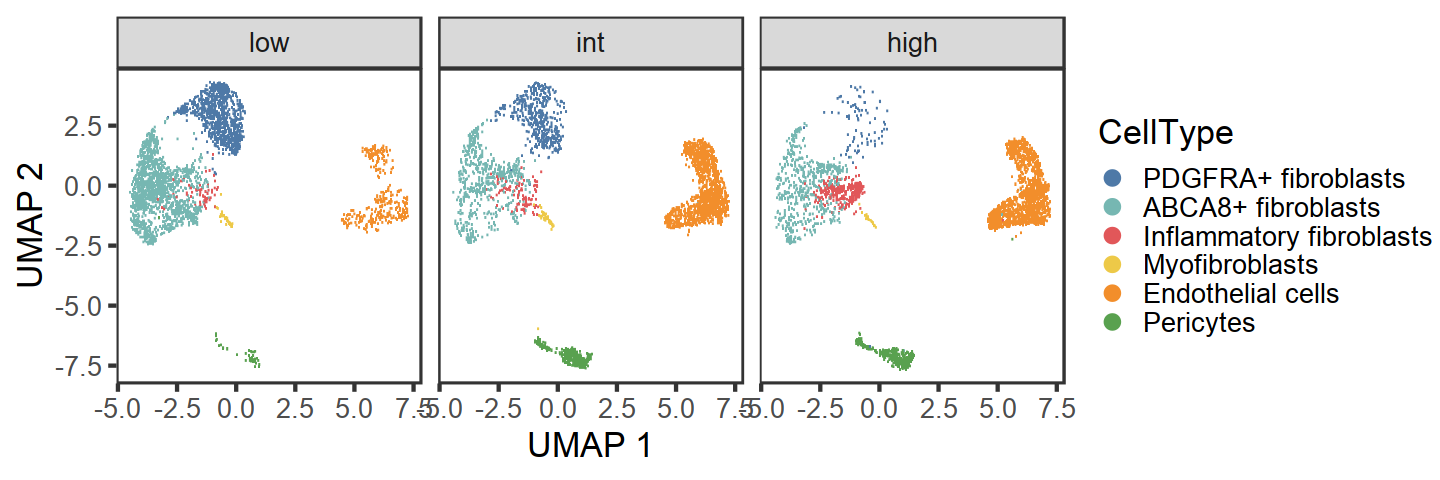

In [7]:
fig.size(4, 12)
do_scatter(roche$umap_after[idx_plot, ], roche$meta_data[idx_plot, ], 'CellType', 
           do_labels = FALSE, no_guides = FALSE, 
           palette_use = colors_global, h=1.5, w=2) + 
    theme_test(base_size = 20) + 
    labs(color = 'CellType', fill = 'CellType') + 
    facet_wrap(~Class)
ggsave('/data/srlab/ik936/Fiona/figures/umap_roche_split.pdf', device = 'pdf', width = 12, height = 4, units = 'in')


## UMAP M4/M5

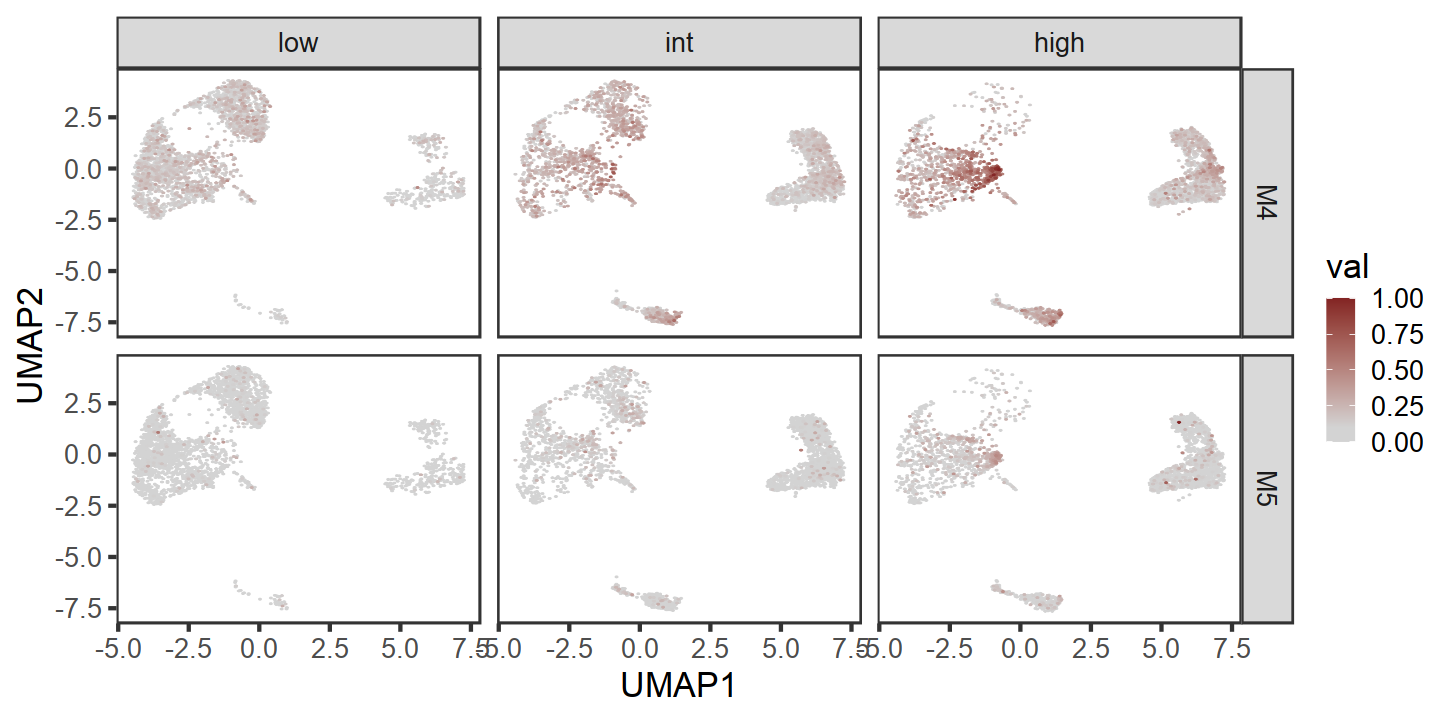

In [8]:
# plotFeatures
fig.size(6, 12)
roche$umap_after[idx_plot, ] %>% 
    cbind(roche$meta_data[idx_plot, ]) %>%
    cbind(apply(roche$scores$m4m5, 2, rescale)[idx_plot, ]) %>% 
    tidyr::gather(key, val, M4, M5) %>% 
    dplyr::arrange(val) %>%
    ggplot(aes(`1`, `2`, color=val)) + 
        geom_point_rast(shape = 16, size = .3, 
                        dpi = 300, height=2, width=2)  + 
        theme_test(base_size = 20) + 
        facet_grid(key~Class) + 
        scale_color_gradient2(midpoint = 0.1, mid = 'lightgrey', low = 'lightgrey', high = muted('red')) + 
        scale_fill_gradient2(midpoint = 0.1, mid = 'lightgrey', low = 'lightgrey', high = muted('red')) + 
        labs(x = 'UMAP1', y = 'UMAP2') + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/umap_roche_m4m5.pdf', device = 'pdf', width = 12, height = 6, units = 'in')


## CXCL expression UMAP

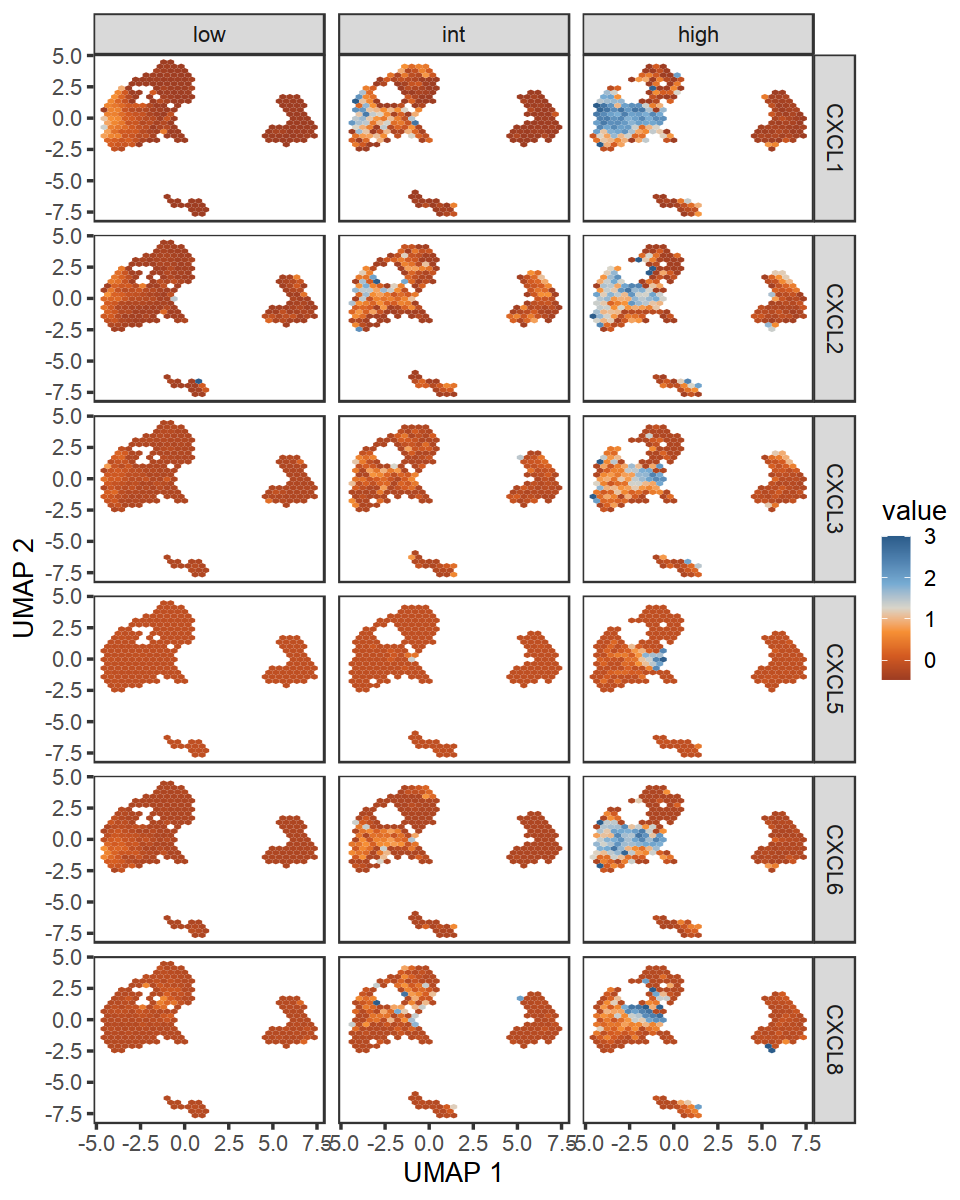

In [9]:
fig.size(10, 8)
roche$umap_after %>% 
    data.table() %>% 
    cbind(roche$meta_data) %>% 
    cbind(
#         t(as.matrix(roche$exprs_norm[unlist(strsplit('CXCL1, CXCL2, CXCL3, CXCL5, CXCL6, CXCL8', ', ')), ]))    
#         scale(t(as.matrix(roche$exprs_norm[unlist(strsplit('CXCL1, CXCL2, CXCL3, CXCL5, CXCL6, CXCL8', ', ')), ])))
        t(singlecellmethods::scaleData(roche$exprs_norm[unlist(strsplit('CXCL1, CXCL2, CXCL3, CXCL5, CXCL6, CXCL8', ', ')), ], thresh = 3))  
    ) %>% 
    tidyr::gather(feature, value, CXCL1:CXCL8) %>% 
    ggplot(aes(V1, V2, z = value)) +
        stat_summary_hex(fun = mean) + 
        facet_grid(feature~Class) + 
        theme_test(base_size = 16) + 
        scale_fill_gradient2_tableau() + 
        labs(x = 'UMAP 1', y = 'UMAP 2') + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/umap_roche_cxcls.pdf', device = 'pdf', width = 8, height = 10, units = 'in')


## Density for M4/M5

In [10]:
## Winsorize to make better use of the space 
X <- apply(roche$scores$m4m5, 2, rescale)
# q99 <-  apply(X, 2, function(x) quantile(x, .99))
# X <- t(apply(X, 1, function(x) pmin(x, q99)))
             

Picking joint bandwidth of 0.0266

Picking joint bandwidth of 0.0137

Picking joint bandwidth of 0.0266

Picking joint bandwidth of 0.0137

Picking joint bandwidth of 0.0266

Picking joint bandwidth of 0.0137

Picking joint bandwidth of 0.0266

Picking joint bandwidth of 0.0137



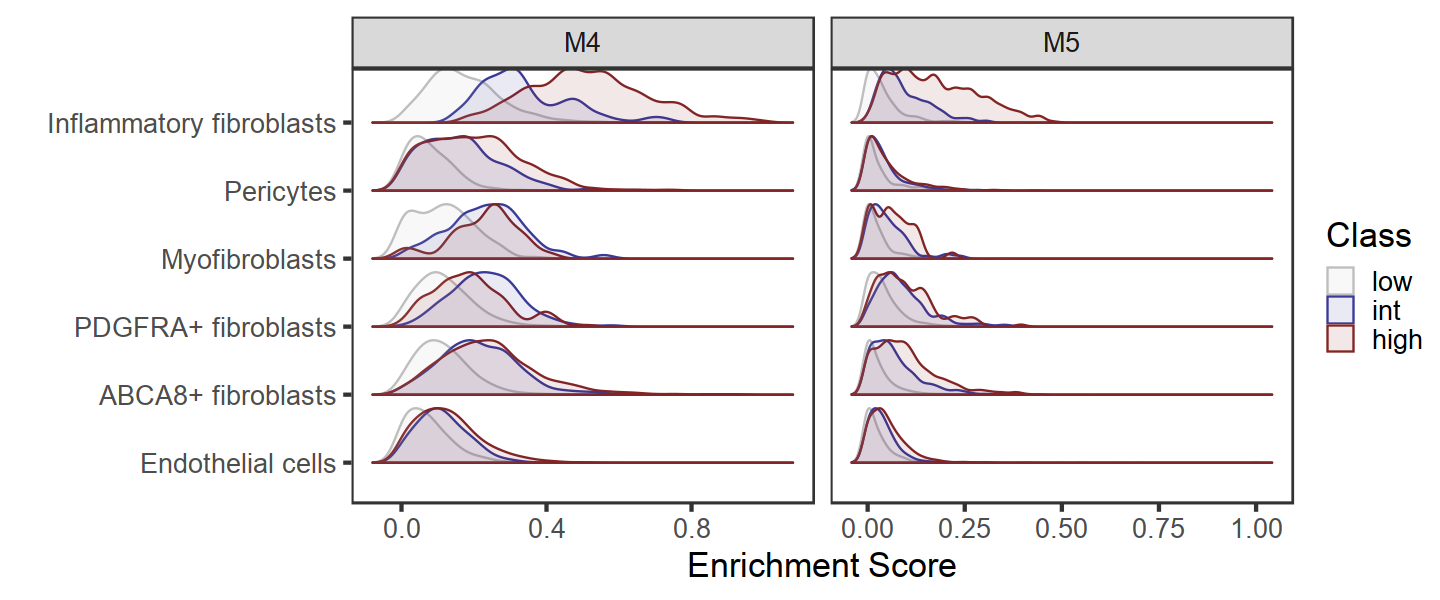

In [11]:
fig.size(5, 12)
roche$umap_after %>% 
    cbind(roche$meta_data) %>%
#     cbind(apply(roche$scores$m4m5, 2, rescale)) %>% 
    cbind(X) %>% 
    tidyr::gather(key, val, M4, M5) %>% 
    ggplot(aes(val, reorder(CellType, val), color = Class, fill = Class)) + 
        geom_density_ridges2(aes(height=..ndensity..), fill = NA, scale = .8) + 
        geom_density_ridges2(aes(height=..ndensity..), alpha = .1, color = NA, scale = .8) + 
        theme_test(base_size = 20) + 
        facet_wrap(~key, scales = 'free_x', nrow=1) +  
        scale_color_manual(values = colors_global) + 
        scale_fill_manual(values = colors_global) + 
        labs(y = '', x = 'Enrichment Score') + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/density_roche_m4m5.pdf', device = 'pdf', width = 12, height = 5, units = 'in')



## LISI

In [13]:
lisi_stats <- data.table(bind_rows(roche$lisi, .id = 'type'))[
        , .(mu = mean(LibraryID), sig = sd(LibraryID)), by = type
    ] %>% 
    tibble::column_to_rownames('type')

## t statistic for change in LISI scores
n <- length(unique(roche$meta_data$LibraryID))
se <- sqrt(1 / n) * (sqrt(lisi_stats['pca', 'sig']^2 + lisi_stats['harmony', 'sig']^2))
stat <- (lisi_stats['pca', 'mu'] - lisi_stats['harmony', 'mu']) / se
2 * (1 - pt(abs(stat), df=n-1))



[1] 0.01610762

Joining, by = "type"



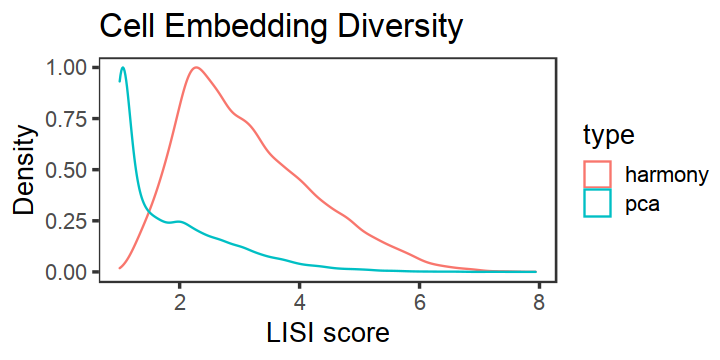

In [14]:
fig.size(3, 6)
bind_rows(roche$lisi, .id = 'type') %>% 
    dplyr::inner_join(data.table(bind_rows(roche$lisi, .id = 'type'))[
        , .(mu = mean(LibraryID), sig = sd(LibraryID)), by = type
    ]) %>% 
#     tidyr::gather(key, val, Class, LibraryID) %>% 
    ggplot(aes(LibraryID, color = type)) + 
        geom_density(aes(y = ..scaled..)) + 
#         geom_vline(aes(xintercept = mu, color = type), linetype = 2) + 
#         geom_density_ridges2() + 
#         facet_wrap(~key, scales = 'free', nrow = 1) + 
        theme_test(base_size = 16) + 
        labs(x = 'LISI score', y = 'Density', title = 'Cell Embedding Diversity') + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/lisi.pdf', device = 'pdf', width = 6, height = 3, units = 'in')



## Proportions

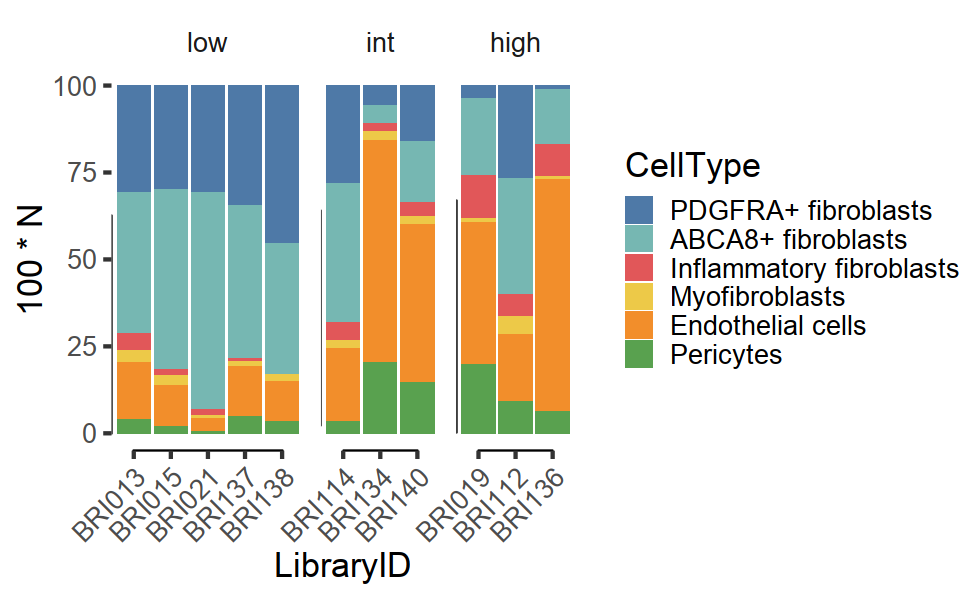

In [15]:
fig.size(5, 8)
roche$proportions_total %>% 
#     dplyr::mutate(sample = factor(sample, sample_order)) %>% 
#     ggplot(aes(reorder(LibraryID, as.integer(sample)), 100 * N, fill = cell_type)) + 
    ggplot(aes(LibraryID, 100 * N, fill = CellType)) + 
        geom_bar(stat = 'identity') + 
#         scale_fill_tableau() + 
        scale_fill_manual(values = colors_global) + 
#         scale_fill_manual(values = c(tableau_color_pal()(10)[1:2], 'grey')) + 
        facet_grid(~Class, scales = 'free', space = 'free') + 
        theme_tufte(base_size = 20) + geom_rangeframe() + 
#         theme(
#             axis.text.x = element_blank(),
#             axis.ticks.x = element_blank()
#         ) + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/roche_barplot.pdf', device = 'pdf', width = 8, height = 5, units = 'in')


## Proportion boxplots

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



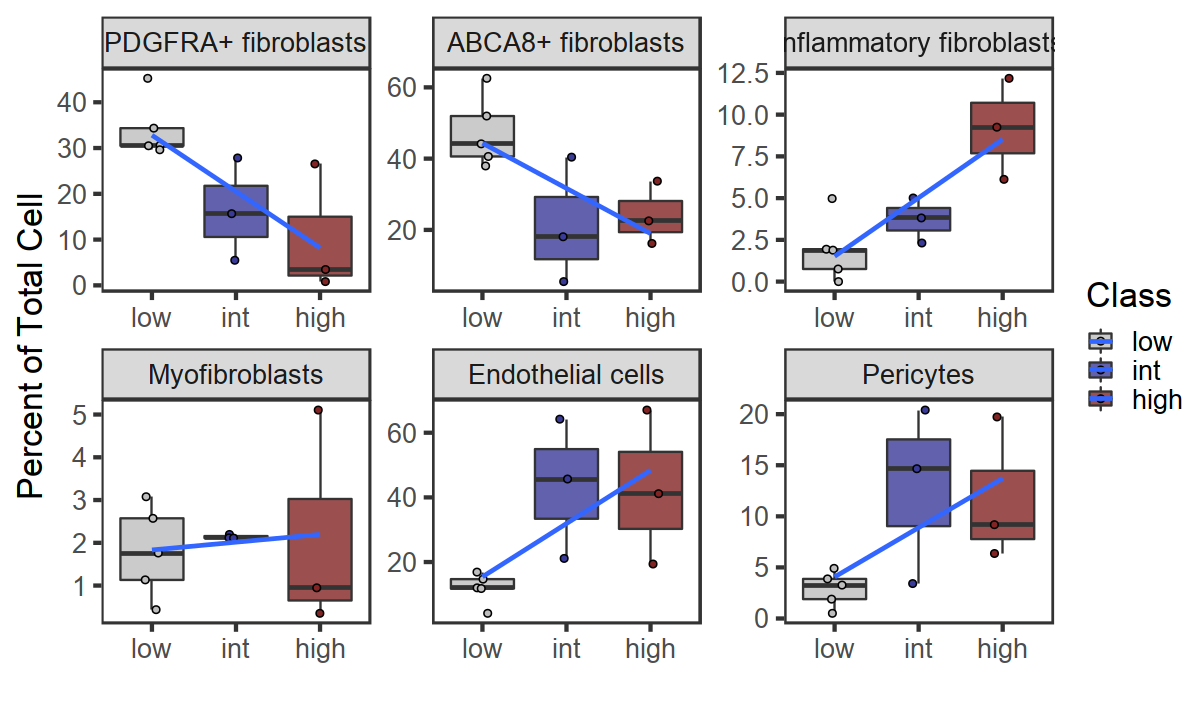

In [16]:
fig.size(6, 10)
roche$proportions_total %>%
    ggplot(aes(Class, 100 * N, fill = Class)) + 
        geom_boxplot(outlier.shape = NA, alpha = .8) + 
        geom_point(shape = 21, position = position_jitter(width = .1)) + 
        theme_test(base_size = 20) + 
        facet_wrap(~CellType, scales = 'free') + 
#         scale_color_tableau() + 
        scale_fill_manual(values = colors_global) + 
        geom_smooth(method = 'lm', data = . %>% dplyr::mutate(Class = as.integer(Class)), se = FALSE) + 
        labs(y = 'Percent of Total Cell', x = '') + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/roche_proportions_boxplot.pdf', device = 'pdf', width = 10, height = 6, units = 'in')


In [66]:
# pvals <- data.table(roche$proportions_total)[
#     , broom::tidy(cor.test(~ N + as.integer(Class), method = 'spearman')), by = CellType
# ][
#     order(p.value)
# ] %>% 
#     mutate(fdr = p.adjust(p.value, 'BH')) %>% 
#     dplyr::select(CellType, p.value)


## Heatmap - cluster markers

In [17]:
do_heat <- function(mods_mat, paletteLength = 50, fname, w, h, nclust_cols=1, do_scale='none', ...) {
    ## scale the rows (modules)
    plt_df <- mods_mat 
    if (do_scale == 'rows') {
        plt_df <- plt_df %>% scale()
    } else if (do_scale == 'cols') {
        plt_df <- plt_df %>% t() %>% scale() %>% t()        
    }


    ## set color scheme
    colors <- c(RColorBrewer::brewer.pal(10, 'RdBu')[1:5], 
                'white',
                RColorBrewer::brewer.pal(10, 'RdBu')[6:10])
    colors <- colorRampPalette(colors)(paletteLength) %>% rev()

    ## set breaks to make zero white
    myBreaks <- c(
        seq(min(plt_df), 0, length.out=ceiling(paletteLength/2) + 1), 
        seq(max(plt_df)/paletteLength, max(plt_df), length.out=floor(paletteLength/2))
    )

    ## plot it! 
    if (!missing(fname)) {
        pheatmap(plt_df, scale = 'none', color = colors, breaks=myBreaks, filename = fname, width = w, height = h, cutree_cols = nclust_cols, ...)  
    } else {
        pheatmap(plt_df, scale = 'none', color = colors, breaks=myBreaks, cutree_cols = nclust_cols, ...)  
    }
}


In [18]:
markers_use <- roche$pb$markers %>%
    top_markers_dds(lfc_min = 2, padj_max = .01) %>% 
    dplyr::select(-rank) %>% 
    purrr::reduce(union) %>% 
    union(c('MCAM', 'ABCA8', 'PDGFRA', 'ACKR1', 'FAP', 'THY1'))


ERROR: Error in top_markers_dds(., lfc_min = 2, padj_max = 0.01): could not find function "top_markers_dds"


Plotting the Wald statistic ($\beta_g / \sigma_g$) is nicer than plotting just the log fold change ($\beta_g$). 


In [ ]:
fig.size(3, 12)
roche$pb$markers %>% 
    subset(feature %in% markers_use) %>% 
    dplyr::select(feature, stat, group) %>% 
    tidyr::spread(group, stat) %>% 
#     dplyr::select(feature, log2FoldChange, group) %>% 
#     tidyr::spread(group, log2FoldChange) %>% 
    tibble::column_to_rownames('feature') %>% 
    t() %>% 
    do_heat(nclust_cols = 7, do_scale='cols', 
#             fname = '/data/srlab/ik936/Fiona/figures/heatmap_roche.pdf', 
            w = 12, h = 3)


## Heatmap Smillie et al 

In [76]:
mods_broad <- readRDS('/data/srlab/ik936/Fiona/data/scores_broad.rds')

In [77]:
fig.size(7, 8.6)
do_heat(mods_broad, fname = '/data/srlab/ik936/Fiona/figures/heatmap_broad.pdf', w = 8.6, h = 7)

## Heatmap Martin et al 

In [72]:
mods_martin <- readRDS('/data/srlab/ik936/Fiona/data/scores_martin.rds')

In [75]:
fig.size(6.5, 4.2)
do_heat(mods_martin, fname = '/data/srlab/ik936/Fiona/figures/heatmap_martin.pdf', w = 4.2, h = 6.5)
do_heat(mods_martin)

## Heatmap - inflam DGEs

$\beta$ for cluster and class. 

In [ ]:
features <- unlist(strsplit(gsub(' ', '', 'CXCL1, CXCL2, CXCL3, CXCL5, CXCL6,CXCL8,THY1, PDPN, FAP'), ',')) %>% 
    union(c('IL11', 'IL24')) %>% 
    union(c('PDGFRA', 'ABCA8'))


In [ ]:
# fig.size(6, 8)
# roche$pb$degs2 %>% 
#     subset(feature %in% features) %>% 
#     tidyr::separate(group, c('Class', 'CellType'), '_') %>% 
#     ggplot(aes(CellType, feature, fill = stat)) + 
#         facet_wrap(~Class) + 
#         geom_tile() +
#         theme_test(base_size = 20) + 
#         scale_fill_gradient2(midpoint = 0, high = tail(colors_heat, 1), low = head(colors_heat, 1)) + 
# #         scale_fill_continuous(colors_heat) + 
#         theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
#         labs(x = '', y = '') + 
#         NULL

# # ggsave('/data/srlab/ik936/Fiona/figures/roche_groups_heatmap_v1.pdf', device = 'pdf', width = 8, height = 6, units = 'in')


In [ ]:
# fig.size(8, 10)
# roche$pb$degs2 %>% 
#     subset(feature %in% features) %>% 
#     tidyr::separate(group, c('Class', 'CellType'), '_') %>% 
#     ggplot(aes(CellType, Class, fill = stat)) + 
#         facet_wrap(~feature) + 
#         geom_tile() +
#         theme_test(base_size = 20) + 
#         scale_fill_gradient2(midpoint = 0) + 
#         theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
#         labs(x = '', y = '') + 
#         NULL
    
# ggsave('/data/srlab/ik936/Fiona/figures/roche_groups_heatmap_v2.pdf', device = 'pdf', width = 10, height = 8, units = 'in')



In [ ]:
fig.size(3, 12)
plt_df <- roche$pb$degs2 %>% 
    tidyr::separate(group, c('Class', 'CellType'), '_') %>% 
    subset(feature %in% features) %>% 
    dplyr::select(feature, stat, Class, CellType) %>%
    tidyr::spread(feature, stat) 

## scale features
plt_df[, 3:ncol(plt_df)] <- scale(plt_df[, 3:ncol(plt_df)])

plt_df <- plt_df %>% 
    dplyr::arrange(CellType)
#     dplyr::arrange(Class)


m <- data.frame(row.names = paste(plt_df$Class, plt_df$CellType, sep = '_'), Class = as.character(plt_df$Class))

In [ ]:
fig.size(5, 6.3)

plt_df %>% 
    tidyr::unite(Class, Class, CellType) %>% 
    tibble::remove_rownames() %>% 
    tibble::column_to_rownames('Class') %>%
do_heat(
    do_scale='none', w = 6.3, h = 5, cluster_rows = FALSE, 
    annotation_row = m, 
    annotation_colors = list(Class = colors_global[c('low', 'int', 'high')]),
    fname = '/data/srlab/ik936/Fiona/figures/roche_groups_heatmap.pdf',
    labels_row = plt_df$CellType,
    gaps_row = seq_len(6) * 3,
    nclust_cols = 2
)


## Endo vs IAFs

In [ ]:
fig.size(4, 6)
plt_df <- rbind(
    roche$proportions_total %>% 
        subset(CellType == 'Endothelial cells'),
    roche$proportions_fibro %>% 
        subset(CellType == 'Inflammatory fibroblasts')
) %>% 
    tidyr::spread(CellType, N) 

plt_df %>% 
    ggplot(aes(100 * `Inflammatory fibroblasts`, 100 * `Endothelial cells`, color = Class)) + 
        geom_point(size = 4) + 
        theme_test(base_size = 20) + 
        geom_smooth(method = 'lm', se = FALSE) + 
        geom_smooth(method = 'lm', se = FALSE, color = 'black', linetype = 2) + 
        labs(
            y = '% Endothelial of Total',
            x = '% Inflammatory Fibroblasts of Fibroblasts'
        ) + 
        scale_color_manual(values = colors_global) + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/roche_ec_iaf_props.pdf', device = 'pdf', width = 6, height = 4, units = 'in')



In [ ]:
library(lme4)
H0 <- lme4::lmer(`Inflammatory fibroblasts` ~ 1 + (1|Class), plt_df, REML=FALSE)
H1 <- lme4::lmer(`Inflammatory fibroblasts` ~ 1 + `Endothelial cells` + (1|Class), plt_df, REML=FALSE)
anova(H0, H1)[2, 'Pr(>Chisq)']
# sprintf('%e', )
# anova(H0, H1)[2, 'Pr(>Chisq)']

## Cytokine response density

In [ ]:
## Winsorize to make better use of the space 
X <- apply(roche$scores$cytokines, 2, rescale)
# q99 <-  apply(X, 2, function(x) quantile(x, .99))
# X <- t(apply(X, 1, function(x) pmin(x, q99)))
             

In [ ]:
fig.size(5, 12)
roche$umap_after %>% 
    cbind(roche$meta_data) %>%
#     cbind(apply(roche$scores$m4m5, 2, rescale)) %>% 
    cbind(X) %>%
#     cbind(val = X[, 'il1b']) %>% 
    tidyr::gather(key, val, osm, il1b, tnf) %>% 
    ggplot(aes(val, reorder(CellType, val), color = Class, fill = Class)) + 
        geom_density_ridges2(aes(height=..ndensity..), fill = NA, scale = .8) + 
        geom_density_ridges2(aes(height=..ndensity..), alpha = .1, color = NA, scale = .8) + 
#         geom_density_ridges2(fill = NA) + 
#         geom_density_ridges2(alpha = .1, color = NA) + 
        theme_test(base_size = 20) + 
        facet_wrap(~key, scales = 'free_x', nrow=1) +  
        scale_color_manual(values = colors_global) + 
        scale_fill_manual(values = colors_global) + 
        labs(y = '', x = 'Enrichment Score') + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/density_roche_il1b.pdf', device = 'pdf', width = 12, height = 5, units = 'in')


## Pseudotime density 

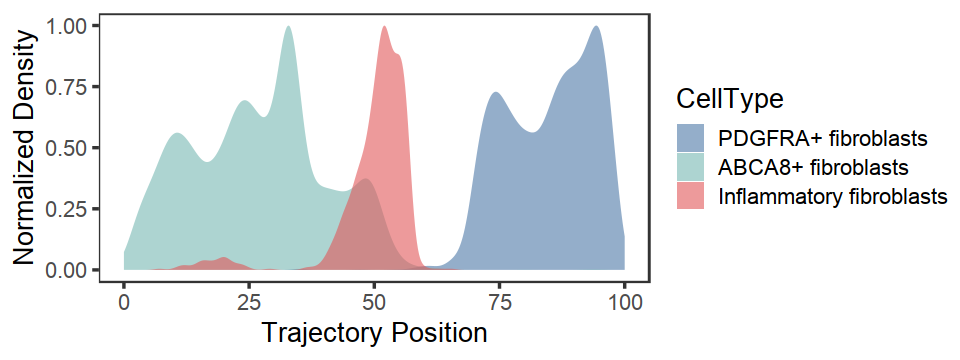

In [70]:
fig.size(3, 8)
roche$meta_data %>% 
    subset(!is.na(pseudotime)) %>% 
    ggplot(aes(100 - pseudotime, fill = CellType)) + 
#         geom_density_ridges2() + 
        geom_density(aes(y = ..ndensity..), color = NA, alpha = .6) + 
        theme_test(base_size = 16) + 
        labs(x = 'Trajectory Position', y = 'Normalized Density') + 
        scale_fill_manual(values = colors_global) + 
#         geom_vline(xintercept = c(32, 59, 82), linetype = 2) + 
#         scale_x_continuous(breaks = c(0, 32, 59, 82, 100)) + 
        NULL
        


ggsave('/data/srlab/ik936/Fiona/figures/density_trajectory.pdf', device = 'pdf', width = 8, height = 3, units = 'in')


## Pseudotime expression

In [65]:
bin_95 <- function(data_df, xvar, yvars, num.bin) {
    data_df <- data.frame(data_df)
    x <- data_df[[xvar]]
    
    .breaks <- unique(quantile(x, probs=seq(0, 1, length.out=num.bin)))
    bin_means <- .5 * (head(.breaks, -1) + tail(.breaks, -1))
    bins_freq <- cut(x, .breaks, include.lowest=TRUE)
    levels(bins_freq) <- bin_means 
    xmeans <- lapply(split(x, as.integer(bins_freq)), mean) %>% as.numeric
    
    res_df <- Reduce(rbind, lapply(yvars, function(yvar) {
        y <- data_df[[yvar]]        
        ymeans <- lapply(split(y, as.integer(bins_freq)), mean) %>% as.numeric
        ysd <- lapply(split(y, as.integer(bins_freq)), sd) %>% as.numeric
        data.frame(xval = xmeans) %>% 
            cbind(
                Reduce(rbind, lapply(split(y, as.integer(bins_freq)), function(.x) quantile(.x, c(.05, .95)))) %>% 
                    data.frame() %>% 
                    dplyr::mutate(symbol = yvar)
            ) %>% 
            cbind(yval = ymeans, ysd = ysd)
             
    })) %>% data.frame()
    return(res_df)
}

In [66]:
idx <- which(!is.na(roche$meta_data$pseudotime))
data_df <- roche$meta_data[idx, ] %>% 
#     cbind(t(scaleData(obj$exprs_norm[c('ABCA8', 'PDPN', 'PDGFRA'), idx]))) %>% 
#     cbind(apply(t(scaleData(roche$exprs_norm[c('ABCA8', 'PDPN', 'PDGFRA'), idx])), 2, rescale)) %>%
    cbind(t(scaleData(roche$exprs_norm[c('ABCA8', 'PDPN', 'PDGFRA'), idx]))) %>%
    bin_95('pseudotime', c('ABCA8', 'PDPN', 'PDGFRA'), 100)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



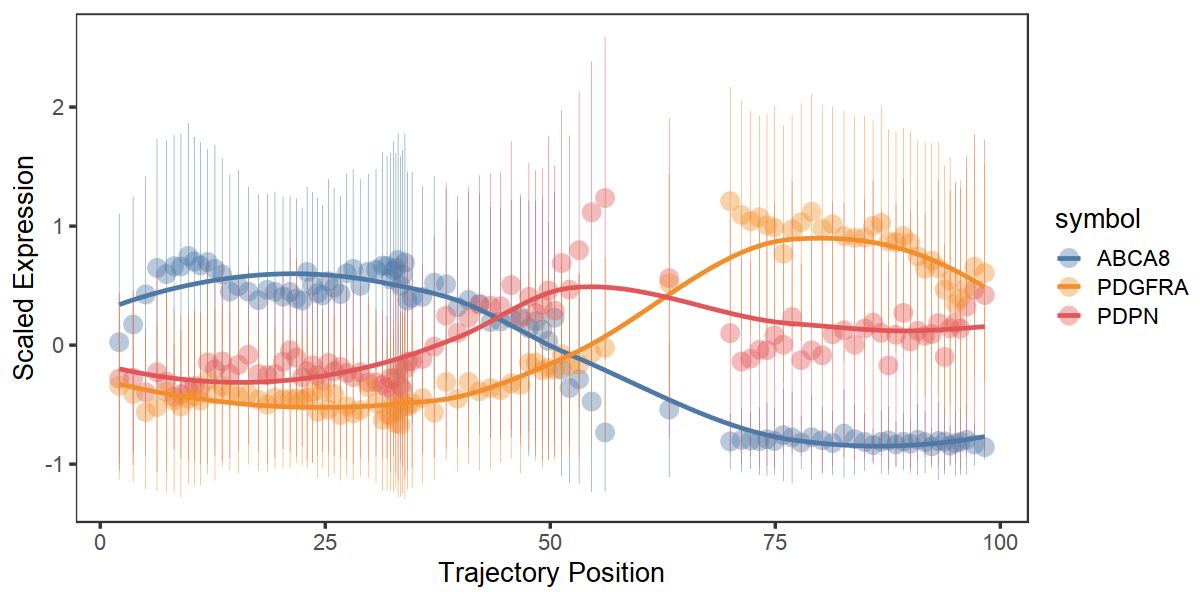

In [71]:
fig.size(5, 10)
data_df %>% 
    ggplot(aes(100 - xval, yval, color = symbol)) + 
        geom_point(shape = 16, size = 5, alpha = .4) + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd), size = .1) +
#         facet_wrap(~key, scales = 'free') + 
        geom_smooth(se = FALSE) + 
        scale_color_tableau() + 
#         scale_color_manual(values = colors_global) + 
        theme_test(base_size = 16) + 
        labs(x = 'Trajectory Position', y = 'Scaled Expression') + 
#         geom_vline(xintercept = c(32, 59, 82), linetype = 2) + 
#         scale_x_continuous(breaks = c(0, 32, 59, 82, 100)) + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/expression_trajectory.pdf', device = 'pdf', width = 8, height = 3, units = 'in')


# Tables

## Table: Cluster markers

In [19]:
dge_markers <- roche$pb$markers %>% 
#     tidyr::separate(group, c('inflammatory_status', 'cell_type'), '_') %>% 
    dplyr::rename(cell_type = group) %>% 
    dplyr::mutate(cell_type = case_when(
        cell_type == 'ABCA8..fibroblasts' ~ 'ABCA8_fibroblasts',
        cell_type == 'PDGFRA..fibroblasts' ~ 'PDGFRA_fibroblasts',
        cell_type == 'Endothelial.cells' ~ 'Endothelial_cells',
        cell_type == 'Inflammatory.fibroblasts' ~ 'Inflammatory_fibroblasts',
        TRUE ~ cell_type
    )) 

head(dge_markers)
table(dge_markers$cell_type)


,feature,cell_type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG,ABCA8_fibroblasts,4.8793773,0.30857843,0.1794243,1.7198247,0.0854643044,0.272230903
2,A1CF,ABCA8_fibroblasts,0.3844001,0.11136877,0.3958244,0.2813591,0.7784350148,0.902115139
3,A2M,ABCA8_fibroblasts,279.4751893,0.69523558,0.2023270,3.4361977,0.0005899402,0.006872876
4,A2ML1,ABCA8_fibroblasts,2.4775387,0.38284454,0.2204759,1.7364463,0.0824849535,0.266055320
5,A4GALT,ABCA8_fibroblasts,23.5846378,0.04505177,0.1610378,0.2797590,0.7796624404,0.902903188
6,AAAS,ABCA8_fibroblasts,5.8623064,0.19224057,0.1775067,1.0830048,0.2788063119,0.544614010



       ABCA8_fibroblasts        Endothelial_cells Inflammatory_fibroblasts 
                   14896                    14896                    14896 
          Myofibroblasts       PDGFRA_fibroblasts                Pericytes 
                   14896                    14896                    14896 

In [20]:
## recalculate missing fdrs
dge_markers <- data.table(dge_markers)[, padj := p.adjust(pvalue, 'BH'), by = .(cell_type)][]

In [21]:
fwrite(dge_markers, '/data/srlab/ik936/Fiona/figures/table_markers_dge.csv', sep=',')


In [22]:
dge_markers %>% 
#     subset(feature %in% c('ABCA8', 'TCF21', 'FBLN5')) %>% ## ABCA8+ fibroblasts
#     subset(feature %in% c('PDGFRA', 'SOX6')) %>% ## PDGFRA+ fibroblasts
#     subset(feature %in% c('MYH11', 'MFAP5', 'ACTG2')) %>% ## Smooth muscle
    subset(feature %in% c('FAP', 'IL11')) %>% ## Smooth muscle
    subset(log2FoldChange > .5 & padj < .05) %>% 
    arrange(-stat)

feature,cell_type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL11,Inflammatory_fibroblasts,14.813555,2.762967,0.5207357,5.305892,1.121233e-07,1.219115e-05
IL11,ABCA8_fibroblasts,14.813555,1.821214,0.5084450,3.581928,3.410675e-04,4.577065e-03
FAP,Inflammatory_fibroblasts,3.551584,1.830072,0.5221946,3.504579,4.573293e-04,1.143016e-02


## Table: Cluster markers (within HIGH) 

In [23]:
dge_markers <- roche$pb$markers_m4m5high %>% 
#     tidyr::separate(group, c('inflammatory_status', 'cell_type'), '_') %>% 
    dplyr::rename(cell_type = group) %>% 
    dplyr::mutate(cell_type = case_when(
        cell_type == 'ABCA8..fibroblasts' ~ 'ABCA8_fibroblasts',
        cell_type == 'PDGFRA..fibroblasts' ~ 'PDGFRA_fibroblasts',
        cell_type == 'Endothelial.cells' ~ 'Endothelial_cells',
        cell_type == 'Inflammatory.fibroblasts' ~ 'Inflammatory_fibroblasts',
        TRUE ~ cell_type
    )) 

head(dge_markers)
table(dge_markers$cell_type)


,feature,cell_type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG,ABCA8_fibroblasts,4.083510,0.21835897,0.4666325,0.4679463,0.6398230,0.9998734
2,A2M,ABCA8_fibroblasts,219.279131,0.26248180,0.3028424,0.8667274,0.3860914,0.9998734
3,A2ML1,ABCA8_fibroblasts,2.580411,0.51755902,0.5271704,0.9817679,0.3262142,NA
4,A4GALT,ABCA8_fibroblasts,26.065518,0.07514055,0.3039443,0.2472181,0.8047394,0.9998734
5,AAAS,ABCA8_fibroblasts,3.926212,0.54633701,0.4830817,1.1309412,0.2580798,0.9998734
6,AACS,ABCA8_fibroblasts,10.074086,0.55898335,0.3821949,1.4625610,0.1435875,0.9758145



       ABCA8_fibroblasts        Endothelial_cells Inflammatory_fibroblasts 
                   13191                    13191                    13191 
          Myofibroblasts       PDGFRA_fibroblasts                Pericytes 
                   13191                    13191                    13191 

In [24]:
## recalculate missing fdrs
dge_markers <- data.table(dge_markers)[, padj := p.adjust(pvalue, 'BH'), by = .(cell_type)][]

In [25]:
fwrite(dge_markers, '/data/srlab/ik936/Fiona/figures/table_markers_dge_m4m5high.csv', sep=',')


In [26]:
fig.size(3, 5)

pdf('/data/srlab/ik936/Fiona/figures/heatmap_markers_m4m5high.pdf', width = 5, height = 3)

dge_markers %>% 
    subset(feature %in% unlist(strsplit('CXCL1, CXCL2, CXCL3, CXCL5, CXCL6, CXCL8', ', '))) %>% 
    dplyr::select(cell_type, feature, stat) %>% 
    tidyr::spread(cell_type, stat) %>% 
    tibble::column_to_rownames('feature') %>% 
    t %>% 
    Heatmap()

dev.off()


png 
  2

In [27]:
fig.size(3, 5)
dge_markers %>% 
    subset(feature %in% unlist(strsplit('CXCL1, CXCL2, CXCL3, CXCL5, CXCL6, CXCL8', ', '))) %>% 
    dplyr::select(cell_type, feature, stat) %>% 
    tidyr::spread(cell_type, stat) 

feature,ABCA8_fibroblasts,Endothelial_cells,Inflammatory_fibroblasts,Myofibroblasts,PDGFRA_fibroblasts,Pericytes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CXCL1,3.0255939,-3.481384,2.447128,0.5420338,-0.85016870,-1.67746150
CXCL2,2.5004214,-1.627447,2.211525,-2.7816443,-0.26840186,0.01942438
CXCL3,1.5496971,-1.739526,3.204972,-1.9990008,0.03753961,-1.01812741
CXCL5,0.9730203,-1.996899,4.490296,-1.1615857,-1.39265942,-0.89122647
CXCL6,2.8706070,-2.531416,3.432331,-0.3837131,-2.06445883,-1.30750653
CXCL8,1.6712776,-2.500863,2.352681,-2.6118852,0.06304908,1.03549469


## Table: Inflam associated DEGs

In [85]:
table(roche$pb$degs2$group)


      high_ABCA8..fibroblasts        high_Endothelial.cells 
                        14896                         14896 
high_Inflammatory.fibroblasts           high_Myofibroblasts 
                        14896                         14896 
     high_PDGFRA..fibroblasts                high_Pericytes 
                        14896                         14896 
       int_ABCA8..fibroblasts         int_Endothelial.cells 
                        14896                         14896 
 int_Inflammatory.fibroblasts            int_Myofibroblasts 
                        14896                         14896 
      int_PDGFRA..fibroblasts                 int_Pericytes 
                        14896                         14896 
       low_ABCA8..fibroblasts         low_Endothelial.cells 
                        14896                         14896 
 low_Inflammatory.fibroblasts            low_Myofibroblasts 
                        14896                         14896 
      low_PDGFRA..fibro

In [ ]:
# dge_status <- roche$pb$degs2 %>% 
    tidyr::separate(group, c('inflammatory_status', 'cell_type'), '_') %>% 
    dplyr::mutate(cell_type = case_when(
        cell_type == 'ABCA8..fibroblasts' ~ 'ABCA8_fibroblasts',
        cell_type == 'PDGFRA..fibroblasts' ~ 'PDGFRA_fibroblasts',
        cell_type == 'Endothelial.cells' ~ 'Endothelial_cells',
        cell_type == 'Inflammatory.fibroblasts' ~ 'Inflammatory_fibroblasts',
        TRUE ~ cell_type
    )) 

head(dge_status)


In [87]:
## recalculate missing fdrs
dge_status <- data.table(dge_status)[, padj := p.adjust(pvalue, 'BH'), by = .(cell_type)][]

In [88]:
fwrite(dge_status, '/data/srlab/ik936/Fiona/figures/table_status_dge.csv', sep=',')

## (optional) IL1R1 expression


In [5]:
## members of the IL1 receptor family 
il1r_genes <- roche$pb$markers %>% 
#     subset(grepl('^IL1R|^IL1B', feature)) %>% 
    subset(grepl('^IL1R|^IL1', feature)) %>% 
    subset(!grepl('IL1\\d', feature)) %>% 
    with(unique(feature))

il1r_genes

[1] "IL1B"     "IL1R1"    "IL1R2"    "IL1RAP"   "IL1RAPL1" "IL1RL1"   "IL1RL2"

In [6]:
il1r_genes <- c('IL1R1', 'TNFRSF1A', 'TNFRSF1B')

Is it differentially expressed among clusters? 


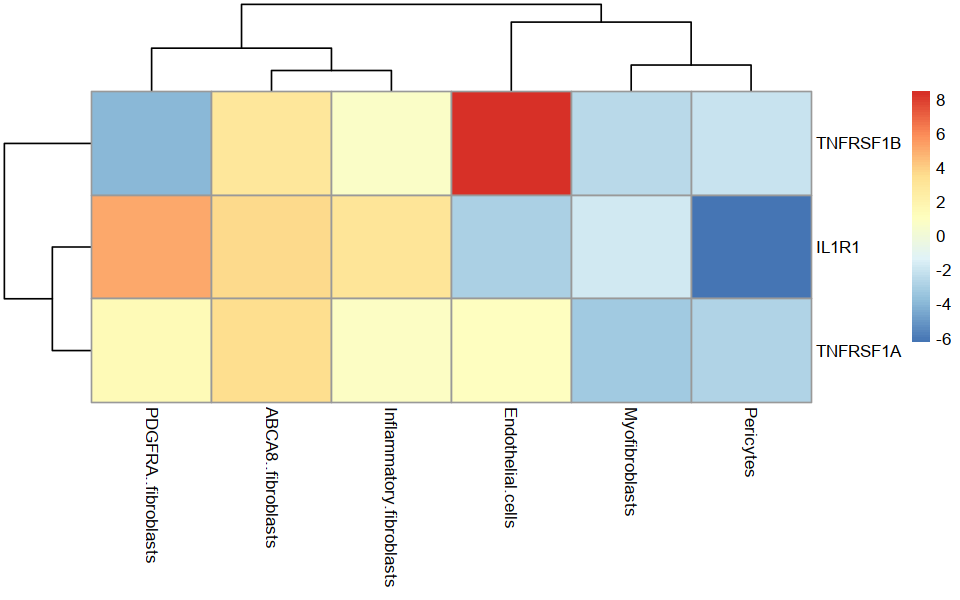

In [7]:
fig.size(5, 8)
roche$pb$markers %>% 
    subset(feature %in% il1r_genes) %>% 
    dplyr::select(feature, group, value = stat) %>% 
    tidyr::spread(group, value) %>% 
    tibble::column_to_rownames('feature') %>% 
    pheatmap(fontsize = 10)


Is it differentially expressed within clusters? 


In [9]:
# fig.size(4.5, 9)
# roche$pb$degs2 %>% 
#     subset(feature %in% il1r_genes) %>% 
# #     arrange(-stat)
#     dplyr::select(feature, group, value = log2FoldChange) %>% 
# #     dplyr::select(feature, group, value = stat) %>% 
#     tidyr::spread(group, value) %>% 
#     tibble::column_to_rownames('feature') %>% 
# #     pheatmap(fontsize = 10, angle_col = '45', )
#     do_heat(angle_col = '90', do_scale = 'row', nclust_cols = 3, fontsize = 14)


In [ ]:
# fig.size(7, 16)
fig.size(7, 12)
roche$pb$degs2 %>% 
#     subset(feature == 'IL1R1') %>% 
    subset(feature %in% il1r_genes) %>% 
    tidyr::separate(group, c('Class', 'CellType'), sep = '_') %>% 
    ggplot(aes(reorder(CellType, -stat), log2FoldChange, color = Class)) + 
        geom_hline(yintercept = c(-1, 0, 1), linetype = 2, color = 'red') + 
        geom_point(shape = 21, size = 3, position = position_dodge(width = 1)) + 
        geom_errorbar(
            aes(ymin = log2FoldChange - lfcSE, ymax = log2FoldChange + lfcSE), width = 0,
            position = position_dodge(width = 1)

        ) + 
        scale_color_manual(values = colors_global) + 
        coord_flip() +         
        theme_test(base_size = 20) + 
        facet_grid(CellType~feature, scales = 'free') + 
        labs(x = '') + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/il1r1_tnfr.pdf', device = 'pdf', width = 12, height = 7, units = 'in')



In [100]:
names(roche$pb)

[1] "counts_mat" "meta_data"  "exprs_norm" "markers"    "degs2"

## (optional) IL1R1, TNFR1, TNFR2

In [98]:
# grep('IL1R1|TNFR', rownames(roche$exprs_norm), value = TRUE)

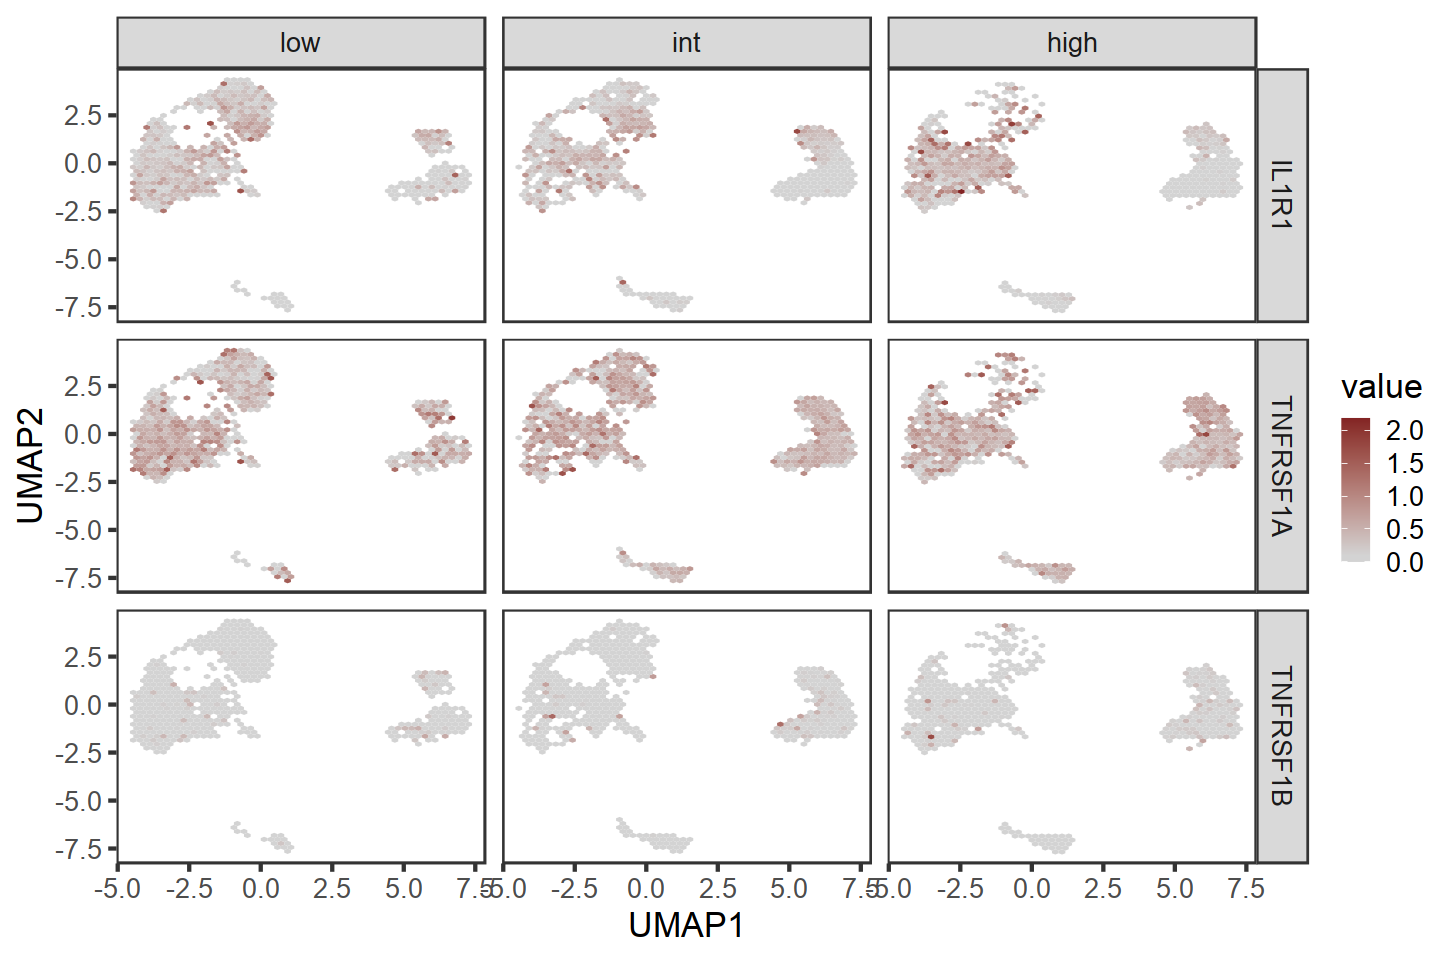

In [99]:
# plotFeatures
fig.size(8, 12)
roche$umap_after[idx_plot, ] %>% 
    cbind(roche$meta_data[idx_plot, ]) %>%
    cbind(as.matrix(t(roche$exprs_norm[c('IL1R1', 'TNFRSF1A', 'TNFRSF1B'), ]))[idx_plot, ]) %>% 
#     cbind(scale(t(roche$exprs_norm[c('IL1R1', 'TNFRSF1A', 'TNFRSF1B'), idx_plot])) %>% pmin(3)) %>% 
#     cbind(scale(t(roche$exprs_norm[c('IL1R1', 'TNFRSF1A', 'TNFRSF1B'), ]))[idx_plot, ]) %>% 
# roche$umap_after %>% 
#     cbind(roche$meta_data) %>%
#     cbind(as.matrix(t(roche$exprs_norm[c('IL1R1', 'TNFRSF1A', 'TNFRSF1B'), ]))) %>% 
#     cbind(scale(t(roche$exprs_norm[c('IL1R1', 'TNFRSF1A', 'TNFRSF1B'), ]))) %>% 
    tidyr::gather(key, val, IL1R1, TNFRSF1A, TNFRSF1B) %>% 
    dplyr::arrange(val) %>%
    ggplot(aes(`1`, `2`, z=val)) + 
        stat_summary_hex(bins = 50, fun = mean) + 
#         geom_point_rast(shape = 16, size = .3, 
#                         dpi = 300, height=2, width=2)  + 
        theme_test(base_size = 20) + 
        facet_grid(key~Class) + 
        scale_color_gradient2(midpoint = 0.1, mid = 'lightgrey', low = 'lightgrey', high = muted('red')) + 
        scale_fill_gradient2(midpoint = 0.1, mid = 'lightgrey', low = 'lightgrey', high = muted('red')) + 
        labs(x = 'UMAP1', y = 'UMAP2') + 
        NULL

ggsave('/data/srlab/ik936/Fiona/figures/umap_roche_il1r1_tnfr1_tnfr2.pdf', device = 'pdf', width = 12, height = 8, units = 'in')
